In [36]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
from scipy.stats.distributions import chi2
import warnings
warnings.filterwarnings('ignore')
from arch import arch_model
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR

In [37]:
raw_data = yf.download(tickers = '^NSEI ^SPX ^N225 ^FTSE', start = '2010-01-01', end = '2023-01-01',interval = '1d', group_by = 'ticker',auto_adjust = True, threads = True)
raw_data.head()
df = raw_data.copy()
df['nifty'] = raw_data['^NSEI'].Close[:]
df['spx'] = raw_data['^SPX'].Close[:]
df['ftse'] = raw_data['^FTSE'].Close[:]
df['n225'] = raw_data['^N225'].Close[:]
#df = df.iloc[1:]
del df['^NSEI']
del df['^SPX']
del df['^FTSE']
del df['^N225']
df = df.asfreq('b')
df['nifty'].fillna(method = 'ffill',inplace = True)
df['spx'].fillna(method = 'ffill',inplace = True)


[*********************100%***********************]  4 of 4 completed


In [38]:
df['Returns_n'] = df.nifty.pct_change(1)*100
df['Returns_s'] = df.spx.pct_change(1)*100
df['Returns_f'] = df.ftse.pct_change(1)*100
df['Returns_n2'] = df.n225.pct_change(1)*100


In [39]:
df_ret = df[["Returns_n","Returns_s","Returns_f","Returns_n2"]][1:]

In [40]:
model_var_ret = VAR(df_ret)
model_var_ret.select_order(20)
ret = model_var_ret.fit(ic = 'aic')
ret.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 29, Jun, 2023
Time:                     13:00:24
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                  -0.149708
Nobs:                     3380.00    HQIC:                 -0.322035
Log likelihood:          -18329.7    FPE:                   0.658410
AIC:                    -0.417931    Det(Omega_mle):        0.630352
--------------------------------------------------------------------
Results for equation Returns_n
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.028596         0.017487            1.635           0.102
L1.Returns_n         -0.077846         0.019179           -4.059           0.000
L1.Returns_s          0.301088         0.020563         

In [42]:
size = int(len(df)*0.8)
df, df_test = df.iloc[:size], df.iloc[size:]
df.tail()


,nifty,spx,ftse,n225,Returns_n,Returns_s,Returns_f,Returns_n2
,,,,,,,,
Date,,,,,,,,
2020-05-20,9066.549805,2971.610107,6067.200195,20595.150391,2.111140,1.665110,1.082936,0.791355
2020-05-21,9106.250000,2948.510010,6015.299805,20552.310547,0.437875,-0.777360,-0.855426,-0.208009
2020-05-22,9039.250000,2955.449951,5993.299805,20388.160156,-0.735758,0.235371,-0.365734,-0.798696
2020-05-25,9039.250000,2955.449951,NaN,20741.650391,0.000000,0.000000,0.000000,1.733802
2020-05-26,9029.049805,2991.770020,6067.799805,21271.169922,-0.112843,1.228918,1.243055,2.552929


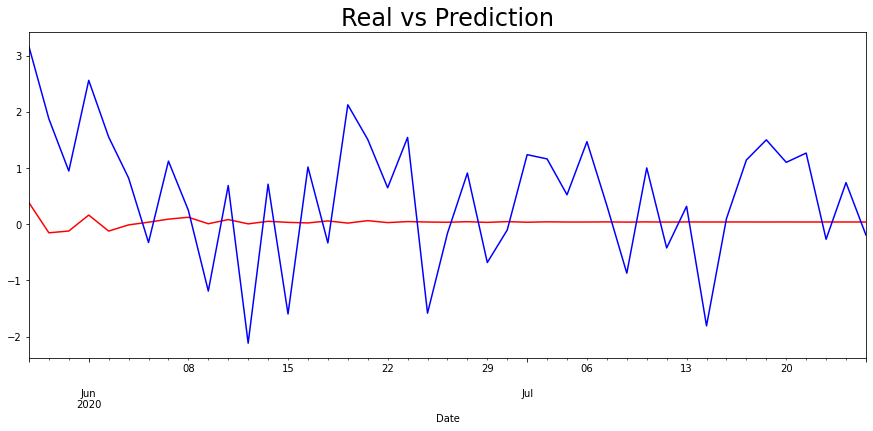

In [43]:
#start and end must be business days otherwise the code will fail
start = '2020-05-27'
end = '2020-07-24'
lag_order_ret = ret.k_ar
var_pred_ret = ret.forecast(df_ret.values[-lag_order_ret:],len(df_test[start:end]))
df_ret_pred = pd.DataFrame(data = var_pred_ret, index = df_test[start:end].index, columns = df_test[start:end].columns[4:8])
df_ret_pred['Returns_n'][start:end].plot(figsize = (15,6), color = 'red')
df_test['Returns_n'][start:end].plot(color = 'blue')
plt.title('Real vs Prediction', size = 24)
plt.show()

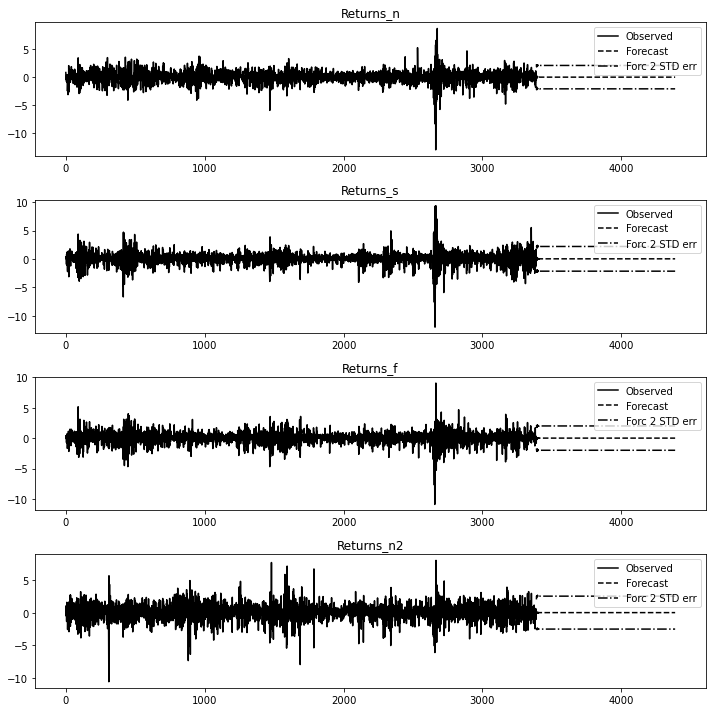

In [48]:
ret.plot_forecast(1000);
plt.tight_layout()

In [51]:
lag_order_ret

9